# Analyzing and visualizing soccer strategy and tactics

In this little project, I was messing around with StatsBomb soccer data. I imagined myself being part of the German Women's national team staff, analyzing the English team right before their finals game in the European Championship 2022.

After finishing my PhD analyzing the NBA, I wanted to look at the sport I played as a teenager again, to see what the data and analytics landscape looks like. So keep this in mind, when reading my thoughts and checking my plots here. Basketball-mind switching sports just for fun to check out the incredibly interesting StatsBomb database, hoping to learn something from interdisciplinary application of methods.


**Intro thoughts on how to evaluate past performance of England (please keep in mind):**

- Coming from basketball analyzing an international soccer tournament, the caveat of sample size cannot be highlighted enough. But of course we can only use the 5 games played before since we want to this particular squad in this particular environment.
- With this particular English team and their path to the final there is even more to take into account. The team swiftly danced through their group games, possibly inflating their stats beating up on weaker opponnents with scoring an unusual amount of goals. 
- While this is a quality not every strong team possesses, tending to coast a little bit an leaving flipping on the switch for the games that really matter (like the Shaq/Kobe Lakers did quite a few times in the beginning of the 2000s), we should value the games after the group stage a little more. There the English team was pushed much more, playing much stronger teams. 
- How they handled this situation should resemble their possible approach to the final much more than their lower pressure, rather easy games from early in the tournament.
- While data is important and can tell us valuable stories, I would also treat the findings with some caution. Only data-points aren't enough. This report would give some advice, but ideally would be confirmed with video scouting as well. I can only show general trends here. However, these analayses might give us interesting, novel starting points for breaking down film.

### Loading Libraries

In [484]:
import matplotlib.patheffects as path_effects
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.colors import LinearSegmentedColormap
from scipy.ndimage import gaussian_filter
from matplotlib.colors import to_rgba
import warnings
from highlight_text import ax_text
import cmasher as cmr
from matplotlib import rcParams



from mplsoccer import Pitch, VerticalPitch, FontManager, Sbopen

### Managing fonts

In [485]:
# fontmanager for google font (robotto)
robotto_regular = FontManager()

# path effects
path_eff = [path_effects.Stroke(linewidth=1.5, foreground='black'),
            path_effects.Normal()]

## Pressure Maps

Let's check first from where England tends to apply pressure from. We can use heatmaps for this.

### Gathering data

In [486]:
# get data
parser = Sbopen()
match_files = [3844384, 3845506, 3835335, 3835327, 3835319]
df = pd.concat([parser.event(file)[0] for file in match_files])  # 0 index is the event file

# filter england pressure and pass events
mask_england_pressure = (df.team_name == "England Women's") & (df.type_name == 'Pressure')
df_pressure = df.loc[mask_england_pressure, ['x', 'y']]
mask_england_pressure = (df.team_name == "England Women's") & (df.type_name == 'Pass')
df_pass = df.loc[mask_england_pressure, ['x', 'y', 'end_x', 'end_y']]


### Plotting pressure heat maps

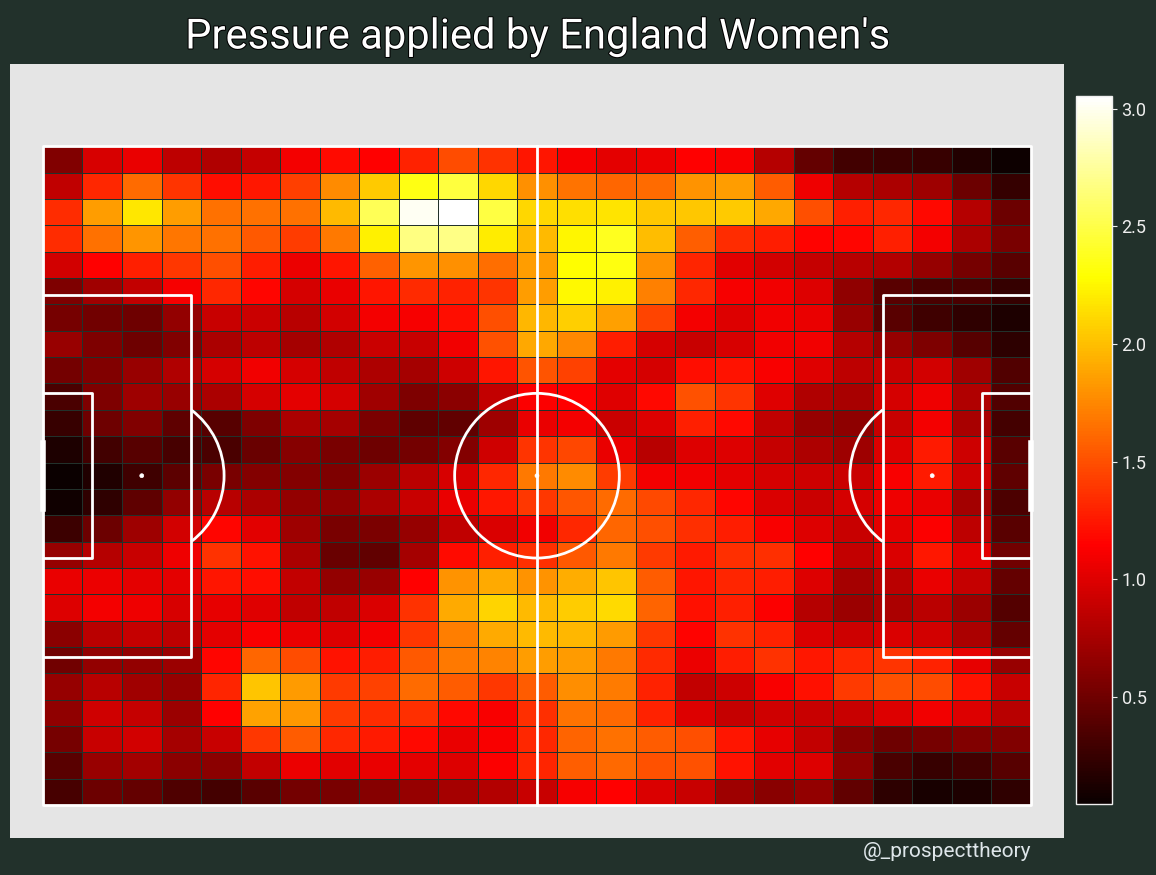

In [487]:
pitch = Pitch(pad_top=10, line_zorder=2)

fig, axs = pitch.grid(endnote_height=0.03, endnote_space=0,
                      # leave some space for the colorbar
                      grid_width=0.88, left=0.025,
                      title_height=0.06, title_space=0,
                      # Turn off the endnote/title axis. I usually do this after
                      # I am happy with the chart layout and text placement
                      axis=False,
                      grid_height=0.86)
fig.set_facecolor('#22312b')

# plot heatmap
bin_statistic = pitch.bin_statistic(df_pressure.x, df_pressure.y, statistic='count', bins=(25, 25))
bin_statistic['statistic'] = gaussian_filter(bin_statistic['statistic'], 1)
pcm = pitch.heatmap(bin_statistic, ax=axs['pitch'], cmap='hot', edgecolors='#22312b')

# add cbar
ax_cbar = fig.add_axes((0.915, 0.093, 0.03, 0.786))
cbar = plt.colorbar(pcm, cax=ax_cbar)
cbar.outline.set_edgecolor('#efefef')
cbar.ax.yaxis.set_tick_params(color='#efefef')
plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='#efefef')
for label in cbar.ax.get_yticklabels():
    label.set_fontproperties(robotto_regular.prop)
    label.set_fontsize(13)

# endnote and title
axs['endnote'].text(1, 0.5, '@_prospecttheory', va='center', ha='right', fontsize=15,
                    fontproperties=robotto_regular.prop, color='#dee6ea')
ax_title = axs['title'].text(0.5, 0.5, "Pressure applied by England Women's", color='white',
                             va='center', ha='center', path_effects=path_eff,
                             fontproperties=robotto_regular.prop, fontsize=30)

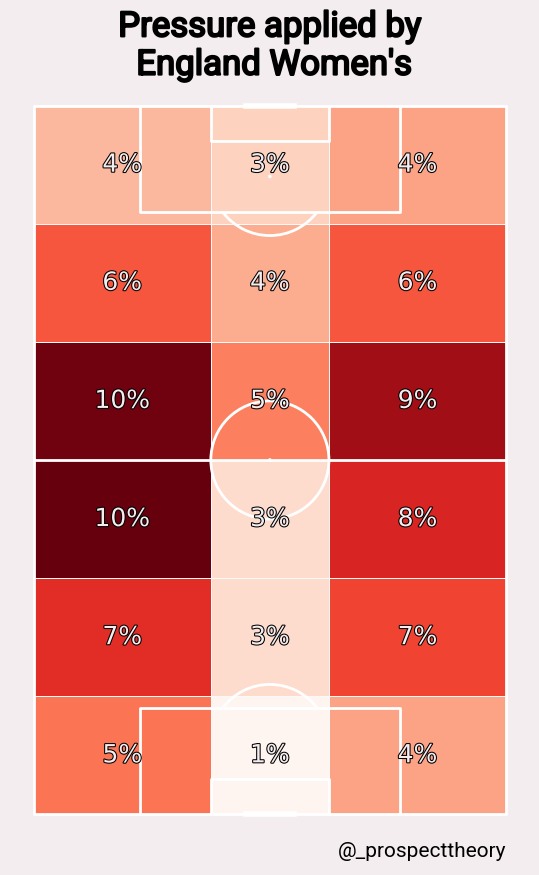

In [488]:
pitch = VerticalPitch(pitch_type='statsbomb', line_zorder=2, pitch_color='#f4edf0')
fig, axs = pitch.grid(endnote_height=0.03, endnote_space=0,
                      title_height=0.08, title_space=0,
                      # Turn off the endnote/title axis. I usually do this after
                      # I am happy with the chart layout and text placement
                      axis=False,
                      grid_height=0.84)
fig.set_facecolor('#f4edf0')

bin_x = np.linspace(pitch.dim.left, pitch.dim.right, num=7)
bin_y = np.sort(np.array([pitch.dim.bottom, pitch.dim.six_yard_bottom,
                          pitch.dim.six_yard_top, pitch.dim.top]))
bin_statistic = pitch.bin_statistic(df_pressure.x, df_pressure.y, statistic='count',
                                    bins=(bin_x, bin_y), normalize=True)
pitch.heatmap(bin_statistic, ax=axs['pitch'], cmap= 'Reds', edgecolor='#f9f9f9')
labels3 = pitch.label_heatmap(bin_statistic, color='#f4edf0', fontsize=18,
                              ax=axs['pitch'], ha='center', va='center',
                              str_format='{:.0%}', path_effects=path_eff)

# endnote and title
endnote_text = axs['endnote'].text(1, 0.5, '@_prospecttheory',
                                   va='center', ha='right', fontsize=15,
                                   fontproperties=robotto_regular.prop, color='Black')
title_text = axs['title'].text(0.5, 0.5, "Pressure applied by\n England Women's",
                               color='Black', va='center', ha='center', path_effects=path_eff,
                               fontproperties=robotto_regular.prop, fontsize=25)

## Juego de Posición

An interesting concept to determine in what areas of the pitch a team tends to possess and handle the ball the most.

### Gathering data

In [489]:
# get data
parser = Sbopen()
match_files = [3844384, 3845506, 3835335, 3835327, 3835319]
df = pd.concat([parser.event(file)[0] for file in match_files])  # 0 index is the event file

# filter england pressure and pass events
mask_england_pressure = (df.team_name == "England Women's") & (df.type_name == 'Pressure')
df_pressure = df.loc[mask_england_pressure, ['x', 'y']]
mask_england_pressure = (df.team_name == "England Women's") & (df.type_name == 'Pass')
df_pass = df.loc[mask_england_pressure, ['x', 'y', 'end_x', 'end_y']]

### Plotting Juego de Posición

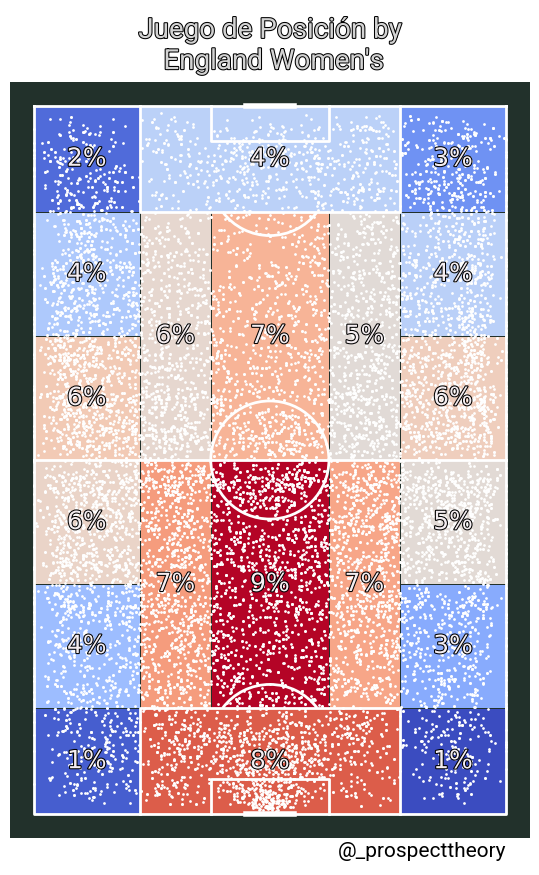

In [490]:
pitch = VerticalPitch(pitch_type='statsbomb', line_zorder=2, pitch_color='#22312b')
fig, axs = pitch.grid(endnote_height=0.03, endnote_space=0,
                      title_height=0.08, title_space=0,
                      # Turn off the endnote/title axis. I usually do this after
                      # I am happy with the chart layout and text placement
                      axis=False,
                      grid_height=0.84)
fig.set_facecolor('White')

# heatmap and labels
bin_statistic = pitch.bin_statistic_positional(df.x, df.y, statistic='count',
                                               positional='full', normalize=True)
pitch.heatmap_positional(bin_statistic, ax=axs['pitch'],
                         cmap='coolwarm', edgecolors='#22312b')

labels = pitch.label_heatmap(bin_statistic, color='#f4edf0', fontsize=18,
                             ax=axs['pitch'], ha='center', va='center',
                             str_format='{:.0%}', path_effects=path_eff)
pitch.scatter(df.x, df.y, c='white', s=2, ax=axs['pitch'])

# endnote and title
axs['endnote'].text(1, 0.5, '@_prospecttheory', va='center', ha='right', fontsize=15,
                    fontproperties=robotto_regular.prop, color='Black')
axs['title'].text(0.5, 0.5, "Juego de Posición by\n England Women's", color='LightGrey',
                  va='center', ha='center', path_effects=path_eff,
                  fontproperties=robotto_regular.prop, fontsize=20)

plt.show() 

## Passing networks

Who passes the ball to whom? An interesting question to look at to identify the most essential connections in a team. Let's have a look at such a network graphically.

### Gathering and preparing data

In [491]:
parser = Sbopen()
events, related, freeze, players = parser.event(3844384)
TEAM = "England Women's"
OPPONENT = "versus Spain Women's (A), Euros 2022"

events.loc[events.tactics_formation.notnull(), 'tactics_id'] = events.loc[
    events.tactics_formation.notnull(), 'id']
events[['tactics_id', 'tactics_formation']] = events.groupby('team_name')[[
    'tactics_id', 'tactics_formation']].ffill()

# Inserting position abbreviations
formation_dict = {1: 'GK', 2: 'RB', 3: 'RCB', 4: 'CB', 5: 'LCB', 6: 'LB', 7: 'RWB',
                  8: 'LWB', 9: 'RDM', 10: 'CDM', 11: 'LDM', 12: 'RM', 13: 'RCM',
                  14: 'CM', 15: 'LCM', 16: 'LM', 17: 'RW', 18: 'RAM', 19: 'CAM',
                  20: 'LAM', 21: 'LW', 22: 'RCF', 23: 'ST', 24: 'LCF', 25: 'SS'}
players['position_abbreviation'] = players.position_id.map(formation_dict)

# Excluding subs as we only want the starting 11
sub = events.loc[events.type_name == 'Substitution',
                 ['tactics_id', 'player_id', 'substitution_replacement_id',
                  'substitution_replacement_name']]
players_sub = players.merge(sub.rename({'tactics_id': 'id'}, axis='columns'),
                            on=['id', 'player_id'], how='inner', validate='1:1')
players_sub = (players_sub[['id', 'substitution_replacement_id', 'position_abbreviation']]
               .rename({'substitution_replacement_id': 'player_id'}, axis='columns'))
players = pd.concat([players, players_sub])
players.rename({'id': 'tactics_id'}, axis='columns', inplace=True)
players = players[['tactics_id', 'player_id', 'position_abbreviation']]

# add on the position the player was playing in the formation to the events dataframe
events = events.merge(players, on=['tactics_id', 'player_id'], how='left', validate='m:1')
# add on the position the receipient was playing in the formation to the events dataframe
events = events.merge(players.rename({'player_id': 'pass_recipient_id'},
                                     axis='columns'), on=['tactics_id', 'pass_recipient_id'],
                      how='left', validate='m:1', suffixes=['', '_receipt'])

In [492]:
# Checking for formation
events.groupby('team_name').tactics_formation.unique()


team_name
England Women's          [4231]
Spain Women's      [4141, 4231]
Name: tactics_formation, dtype: object

### Plotting passing network

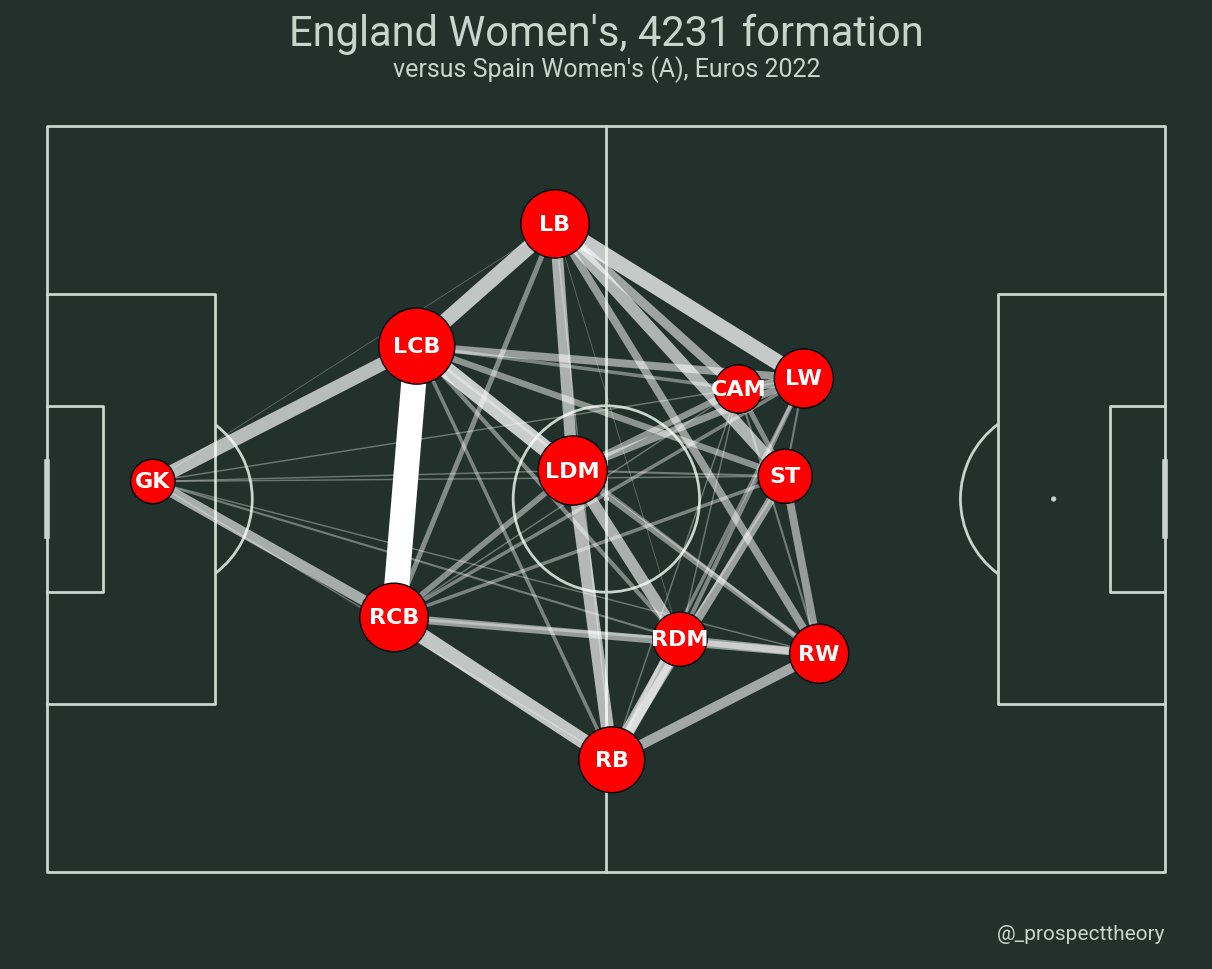

In [493]:
FORMATION = '4231'

pass_cols = ['id', 'position_abbreviation', 'position_abbreviation_receipt']
passes_formation = events.loc[(events.team_name == TEAM) & (events.type_name == 'Pass') &
                              (events.tactics_formation == FORMATION) &
                              (events.position_abbreviation_receipt.notnull()), pass_cols].copy()
location_cols = ['position_abbreviation', 'x', 'y']
location_formation = events.loc[(events.team_name == TEAM) &
                                (events.type_name.isin(['Pass', 'Ball Receipt'])) &
                                (events.tactics_formation == FORMATION), location_cols].copy()

# average locations
average_locs_and_count = (location_formation.groupby('position_abbreviation')
                          .agg({'x': ['mean'], 'y': ['mean', 'count']}))
average_locs_and_count.columns = ['x', 'y', 'count']

# calculate the number of passes between each position (using min/ max so we get passes both ways)
passes_formation['pos_max'] = (passes_formation[['position_abbreviation',
                                                'position_abbreviation_receipt']]
                               .max(axis='columns'))
passes_formation['pos_min'] = (passes_formation[['position_abbreviation',
                                                'position_abbreviation_receipt']]
                               .min(axis='columns'))
passes_between = passes_formation.groupby(['pos_min', 'pos_max']).id.count().reset_index()
passes_between.rename({'id': 'pass_count'}, axis='columns', inplace=True)

# add on the location of each player so we have the start and end positions of the lines
passes_between = passes_between.merge(average_locs_and_count, left_on='pos_min', right_index=True)
passes_between = passes_between.merge(average_locs_and_count, left_on='pos_max', right_index=True,
                                      suffixes=['', '_end'])
MAX_LINE_WIDTH = 18
MAX_MARKER_SIZE = 3000
passes_between['width'] = (passes_between.pass_count / passes_between.pass_count.max() *
                           MAX_LINE_WIDTH)
average_locs_and_count['marker_size'] = (average_locs_and_count['count']
                                         / average_locs_and_count['count'].max() * MAX_MARKER_SIZE)
MIN_TRANSPARENCY = 0.3
color = np.array(to_rgba('white'))
color = np.tile(color, (len(passes_between), 1))
c_transparency = passes_between.pass_count / passes_between.pass_count.max()
c_transparency = (c_transparency * (1 - MIN_TRANSPARENCY)) + MIN_TRANSPARENCY
color[:, 3] = c_transparency


pitch = Pitch(pitch_type='statsbomb', pitch_color='#22312b', line_color='#c7d5cc')
fig, axs = pitch.grid(figheight=10, title_height=0.08, endnote_space=0,
                      # Turn off the endnote/title axis. I usually do this after
                      # I am happy with the chart layout and text placement
                      axis=False,
                      title_space=0, grid_height=0.82, endnote_height=0.05)
fig.set_facecolor("#22312b")
pass_lines = pitch.lines(passes_between.x, passes_between.y,
                         passes_between.x_end, passes_between.y_end, lw=passes_between.width,
                         color=color, zorder=1, ax=axs['pitch'])
pass_nodes = pitch.scatter(average_locs_and_count.x, average_locs_and_count.y,
                           s=average_locs_and_count.marker_size,
                           color='red', edgecolors='black', linewidth=1, alpha=1, ax=axs['pitch'])
for index, row in average_locs_and_count.iterrows():
    pitch.annotate(row.name, xy=(row.x, row.y), c='white', va='center',
                   ha='center', size=16, weight='bold', ax=axs['pitch'])

# Load a custom font.
URL = 'https://raw.githubusercontent.com/google/fonts/main/apache/roboto/Roboto%5Bwdth,wght%5D.ttf'
robotto_regular = FontManager(URL)

# endnote /title
axs['endnote'].text(1, 0.5, '@_prospecttheory', color='#c7d5cc',
                    va='center', ha='right', fontsize=15,
                    fontproperties=robotto_regular.prop)
TITLE_TEXT = f'{TEAM}, {FORMATION} formation'
axs['title'].text(0.5, 0.7, TITLE_TEXT, color='#c7d5cc',
                  va='center', ha='center', fontproperties=robotto_regular.prop, fontsize=30)
axs['title'].text(0.5, 0.25, OPPONENT, color='#c7d5cc',
                  va='center', ha='center', fontproperties=robotto_regular.prop, fontsize=18)

plt.show()

## Pass Receptions by Player

Isn't it interesting to know where a player tends to get the ball? It shows their range of motion and areas of onball-impact. This allows to understand team tendencies as well as individual preferences.

### Gathering data

In [494]:
parser = Sbopen()
event, related, freeze, tactics = parser.event(3844384)
# starting players from Barcelona
starting_xi_event = event.loc[((event['type_name'] == 'Starting XI') &
                               (event['team_name'] == "England Women's")), ['id', 'tactics_formation']]
# joining on the team name and formation to the lineup
starting_xi = tactics.merge(starting_xi_event, on='id')

# filter only succesful ball receipts from the starting XI
event = event.loc[((event['type_name'] == 'Ball Receipt') &
                   (event['outcome_name'].isnull()) &
                   (event['player_id'].isin(starting_xi['player_id']))
                   ), ['player_id', 'x', 'y']]
# merge on the starting positions to the events
event = event.merge(starting_xi, on='player_id')
formation = event['tactics_formation'].iloc[0]

### Plotting the reception maps for all starters

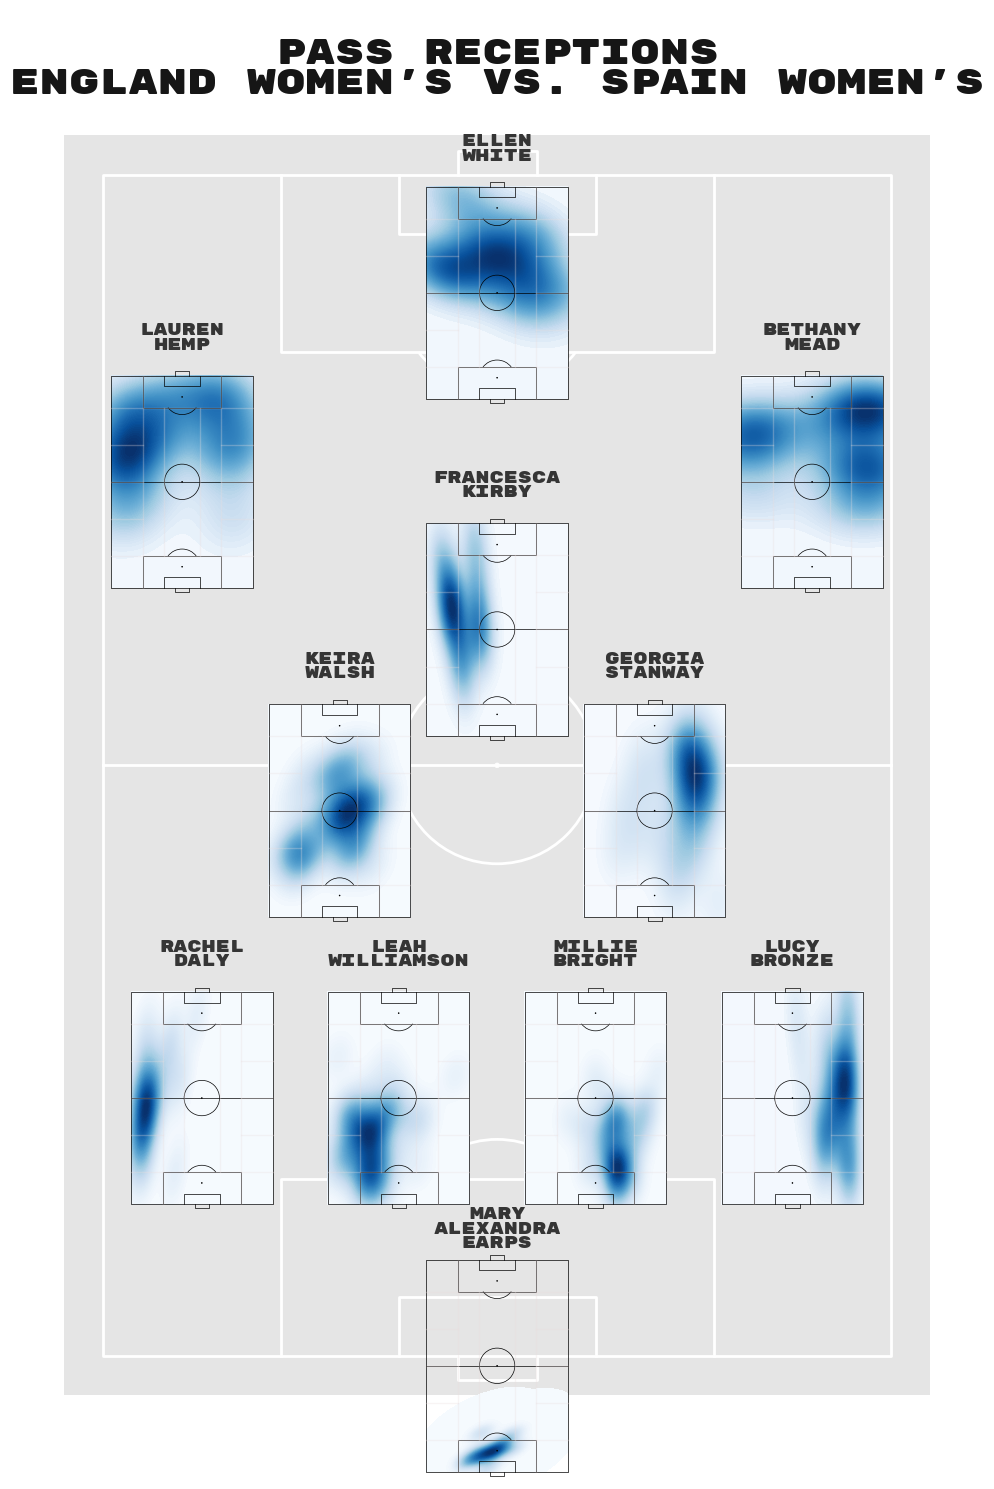

In [495]:
pitch = VerticalPitch(goal_type='box')
fig, axs = pitch.grid(endnote_height=0, title_height=0.08, figheight=14, grid_width=0.9,
                      grid_height=0.9, axis=False)
fm_rubik = FontManager('https://raw.githubusercontent.com/google/fonts/main/ofl/'
                       'rubikmonoone/RubikMonoOne-Regular.ttf')
title = axs['title'].text(0.5, 0.5, "Pass receptions\nEngland Women's vs. Spain Women's", fontsize=25,
                          va='center',
                          ha='center', color='#161616', fontproperties=fm_rubik.prop)

pitch_ax = pitch.formation(formation,
                           kind='pitch',
                           # avoid overlapping pitches with offsets
                           xoffset=[-13,-5,-5,-5,-5,5, 5, 0, -15, 0, 0],
                           # pitch is 23 units long (could also set the height).
                           # note this is set assuming the pitch is horizontal, but in this example
                           # it is vertical so that you get the same results
                           # from both VerticalPitch and Pitch
                           width=23,
                           positions=starting_xi['position_id'],
                           ax=axs['pitch'],
                           # additional arguments temporarily amend the pitch appearance
                           # note we are plotting a really faint positional grid
                           # that overlays the kdeplot
                           linewidth=0.5,
                           pitch_color='None',
                           line_zorder=3,
                           line_color='black',
                           positional=True,
                           positional_zorder=3,
                           positional_linewidth=1,
                           positional_alpha=0.3,
                           )


# adding kdeplot and player titles
for position in pitch_ax:
    player_name = starting_xi[starting_xi['position_id'] == position].player_name.iloc[0]
    player_name = player_name.replace(' ', '\n').replace('-', '-\n')
    pitch.text(150, 40, player_name, va='top', ha='center', fontsize=12, ax=pitch_ax[position],
               fontproperties=fm_rubik.prop, color='#353535')
    pitch.kdeplot(x=event.loc[event['position_id'] == position, 'x'],
                  y=event.loc[event['position_id'] == position, 'y'],
                  fill=True, levels=100, cut=100, cmap='Blues', thresh=0, ax=pitch_ax[position])
    


## Mapping individual passing efforts

Charting players in this way helps us understand what kind of passes an athlete tends to complete and which they don't. This knowledge provides some interesting scheming options.

### Gathering and preparing data

In [496]:
parser = Sbopen()
events, related, freeze, tactics = parser.event(3844384)
lineup = parser.lineup(3844384)

In [497]:
# dataframe with player_id and when they were subbed off
time_off = events.loc[(events.type_name == 'Substitution'),
                      ['player_id', 'minute']]
time_off.rename({'minute': 'off'}, axis='columns', inplace=True)
# dataframe with player_id and when they were subbed on
time_on = events.loc[(events.type_name == 'Substitution'),
                     ['substitution_replacement_id', 'minute']]
time_on.rename({'substitution_replacement_id': 'player_id',
                'minute': 'on'}, axis='columns', inplace=True)
players_on = time_on.player_id
# merge on times subbed on/off
lineup = lineup.merge(time_on, on='player_id', how='left')
lineup = lineup.merge(time_off, on='player_id', how='left')

In [498]:
# filter the tactics lineup for the starting xi
starting_ids = events[events.type_name == 'Starting XI'].id
starting_xi = tactics[tactics.id.isin(starting_ids)]
starting_players = starting_xi.player_id

# filter the lineup for players that actually played
mask_played = ((lineup.on.notnull()) | (lineup.off.notnull()) |
               (lineup.player_id.isin(starting_players)))
lineup = lineup[mask_played].copy()

# get the first position for each player and add this to the lineup dataframe
player_positions = (events[['player_id', 'position_id']]
                    .dropna(how='any', axis='rows')
                    .drop_duplicates('player_id', keep='first'))
lineup = lineup.merge(player_positions, how='left', on='player_id')

# add on the position abbreviation
formation_dict = {1: 'GK', 2: 'RB', 3: 'RCB', 4: 'CB', 5: 'LCB', 6: 'LB', 7: 'RWB',
                  8: 'LWB', 9: 'RDM', 10: 'CDM', 11: 'LDM', 12: 'RM', 13: 'RCM',
                  14: 'CM', 15: 'LCM', 16: 'LM', 17: 'RW', 18: 'RAM', 19: 'CAM',
                  20: 'LAM', 21: 'LW', 22: 'RCF', 23: 'ST', 24: 'LCF', 25: 'SS'}
lineup['position_abbreviation'] = lineup.position_id.map(formation_dict)

# sort the dataframe so the players are
# in the order of their position (if started), otherwise in the order they came on
lineup['start'] = lineup.player_id.isin(starting_players)
lineup.sort_values(['team_name', 'start', 'on', 'position_id'],
                   ascending=[True, False, True, True], inplace=True)

In [499]:
# filter the lineup for English players
# if you want the other team set team = team2
team1, team2 = lineup.team_name.unique()  # England (team1), Spain (team2)
team = team1
lineup_team = lineup[lineup.team_name == team].copy()

# filter the events to exclude some set pieces
set_pieces = ['Throw-in', 'Free Kick', 'Corner', 'Kick Off', 'Goal Kick']
# for the team pass map
pass_receipts = events[(events.team_name == team) & (events.type_name == 'Ball Receipt')].copy()
# for the player pass maps
passes_excl_throw = events[(events.team_name == team) & (events.type_name == 'Pass') &
                           (events.sub_type_name != 'Throw-in')].copy()

# identify how many players played and how many subs were used
# we will use this in the loop for only plotting pass maps for as
# many players who played
num_players = len(lineup_team)
num_sub = num_players - 11

# add padding to the top so we can plot the titles, and raise the pitch lines
pitch = Pitch(pad_top=10, line_zorder=2)

# arrow properties for the sub on/off
green_arrow = dict(arrowstyle='simple, head_width=0.7',
                   connectionstyle="arc3,rad=-0.8", fc="green", ec="green")
red_arrow = dict(arrowstyle='simple, head_width=0.7',
                 connectionstyle="arc3,rad=-0.8", fc="red", ec="red")

# a fontmanager object for using a google font
fm_scada = FontManager('https://raw.githubusercontent.com/googlefonts/scada/main/fonts/ttf/'
                       'Scada-Regular.ttf')

### Plotting the individual passing maps

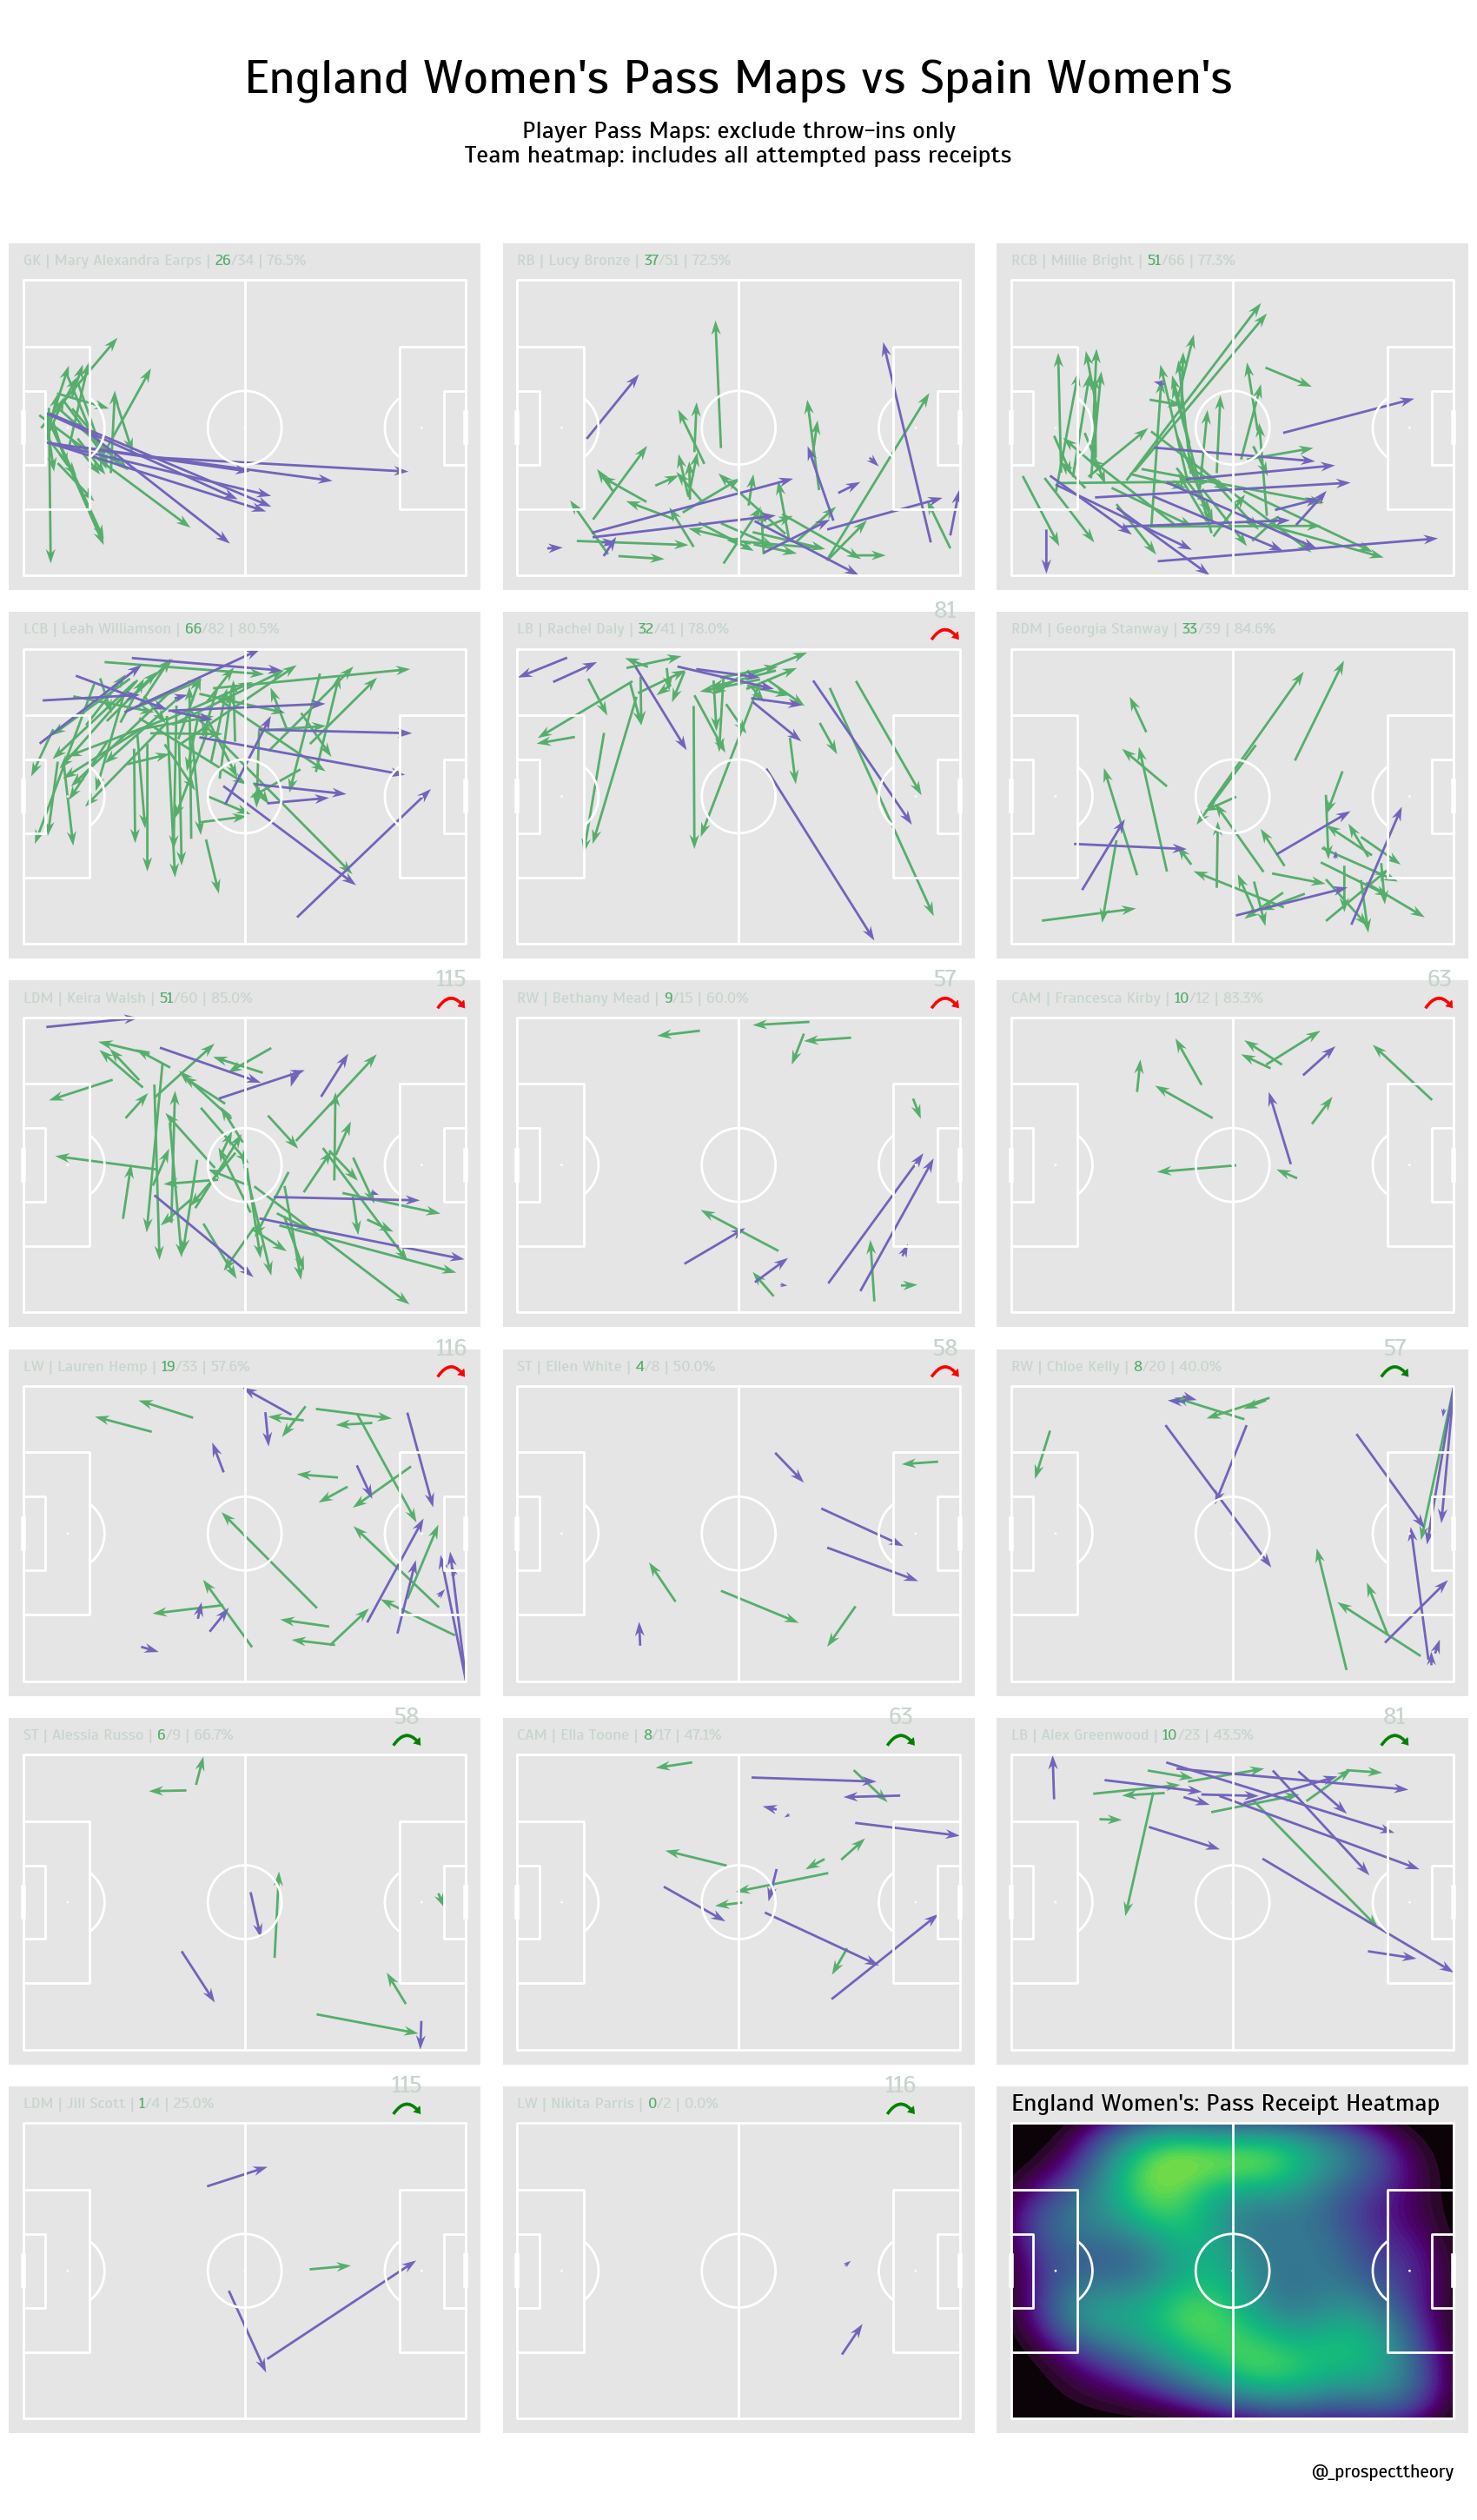

In [500]:
# filtering out some highlight_text warnings - the warnings aren't correct as the
# text fits inside the axes.
warnings.simplefilter("ignore", UserWarning)

# plot the 5 * 3 grid
fig, axs = pitch.grid(nrows=6, ncols=3, figheight=30,
                      endnote_height=0.03, endnote_space=0,
                      # Turn off the endnote/title axis. I usually do this after
                      # I am happy with the chart layout and text placement
                      axis=False,
                      title_height=0.08, grid_height=0.84)
# cycle through the grid axes and plot the player pass maps
for idx, ax in enumerate(axs['pitch'].flat):
    # only plot the pass maps up to the total number of players
    if idx < num_players:
        # filter the complete/incomplete passes for each player (excudes throw-ins)
        lineup_player = lineup_team.iloc[idx]
        player_id = lineup_player.player_id
        player_pass = passes_excl_throw[passes_excl_throw.player_id == player_id]
        complete_pass = player_pass[player_pass.outcome_name.isnull()]
        incomplete_pass = player_pass[player_pass.outcome_name.notnull()]

        # plot the arrows
        pitch.arrows(complete_pass.x, complete_pass.y,
                     complete_pass.end_x, complete_pass.end_y,
                     color='#56ae6c', width=2, headwidth=4, headlength=6, ax=ax)
        pitch.arrows(incomplete_pass.x, incomplete_pass.y,
                     incomplete_pass.end_x, incomplete_pass.end_y,
                     color='#7065bb', width=2, headwidth=4, headlength=6, ax=ax)

        # plot the title for each player axis
        # here we use f-strings to combine the variables from the dataframe and text
        # we plot the title at x=0, y=-5
        # this is the left hand-side of the pitch (x=0) and between
        # top of the y-axis (y=0) and the top of the padding (y=-10, remember pad_top = 10)
        # note that the StatsBomb y-axis is inverted, so you may need
        # to change this if you use another pitch_type (e.g. 'uefa').
        # We also use the highlight-text package to highlight complete_pass green
        # so put <> around the number of completed passes.
        total_pass = len(complete_pass) + len(incomplete_pass)
        annotation_string = (f'{lineup_player.position_abbreviation} | '
                             f'{lineup_player.player_name} | '
                             f'<{len(complete_pass)}>/{total_pass} | '
                             f'{round(100 * len(complete_pass)/total_pass, 1)}%')
        ax_text(0, -5, annotation_string, ha='left', va='center', fontsize=13,
                fontproperties=fm_scada.prop,  # using the fontmanager for the google font
                highlight_textprops=[{"color": '#56ae6c'}], ax=ax)

        # add information for subsitutions on/off and arrows
        if not np.isnan(lineup_team.iloc[idx].off):
            ax.text(116, -10, str(lineup_team.iloc[idx].off.astype(int)), fontsize=20,
                    fontproperties=fm_scada.prop,
                    ha='center', va='center')
            ax.annotate('', (120, -2), (112, -2), arrowprops=red_arrow)
        if not np.isnan(lineup_team.iloc[idx].on):
            ax.text(104, -10, str(lineup_team.iloc[idx].on.astype(int)), fontsize=20,
                    fontproperties=fm_scada.prop,
                    ha='center', va='center')
            ax.annotate('', (108, -2), (100, -2), arrowprops=green_arrow)

# plot on the last Pass Map
# (note ax=ax as we have cycled through to the last axes in the loop)
pitch.kdeplot(x=pass_receipts.x, y=pass_receipts.y, ax=ax,
              cmap=cmr.lavender,
              levels=100,
              thresh=0, fill=True)
ax.text(0, -5, f'{team}: Pass Receipt Heatmap', ha='left', va='center',
        fontsize=20, fontproperties=fm_scada.prop, color = 'black')

# remove unused axes (if any)
for ax in axs['pitch'].flat[11 + num_sub:-1]:
    ax.remove()

# title text
axs['title'].text(0.5, 0.65, f'{team1} Pass Maps vs {team2}', fontsize=40,
                  fontproperties=fm_scada.prop, va='center', ha='center', color = 'black')
SUB_TEXT = ('Player Pass Maps: exclude throw-ins only\n'
            'Team heatmap: includes all attempted pass receipts')
axs['title'].text(0.5, 0.35, SUB_TEXT, fontsize=20,
                  fontproperties=fm_scada.prop, va='center', ha='center', color = 'black')

# endnote
axs['endnote'].text(1, 0.5, '@_prospecttheory',
                    va='center', ha='right', fontsize=15,
                    fontproperties=fm_scada.prop, color = 'black')


plt.show()

## Passes that led to shots

Looking at how teams typically set up shot might help defenses to guard against such opportunities in the future.

### Gathering and preparing data

In [501]:
# get event dataframe for game 7478
parser = Sbopen()


df, related, freeze, tactics = parser.event(3844384)

team1, team2 = df.team_name.unique()
mask_team1 = (df.type_name == 'Pass') & (df.team_name == team1)

df_pass = df.loc[mask_team1, ['x', 'y', 'end_x', 'end_y', 'outcome_name']]
mask_complete = df_pass.outcome_name.isnull()



In [502]:
TEAM1 = "England Women's"
TEAM2 = "Spain Women's"
df_pass = df.loc[(df.pass_assisted_shot_id.notnull()) & (df.team_name == TEAM1),
                 ['x', 'y', 'end_x', 'end_y', 'pass_assisted_shot_id']]

df_shot = (df.loc[(df.type_name == 'Shot') & (df.team_name == TEAM1),
                  ['id', 'outcome_name', 'shot_statsbomb_xg']]
           .rename({'id': 'pass_assisted_shot_id'}, axis=1))

df_pass = df_pass.merge(df_shot, how='left').drop('pass_assisted_shot_id', axis=1)

mask_goal = df_pass.outcome_name == 'Goal'

### Plotting the passes that led to shots

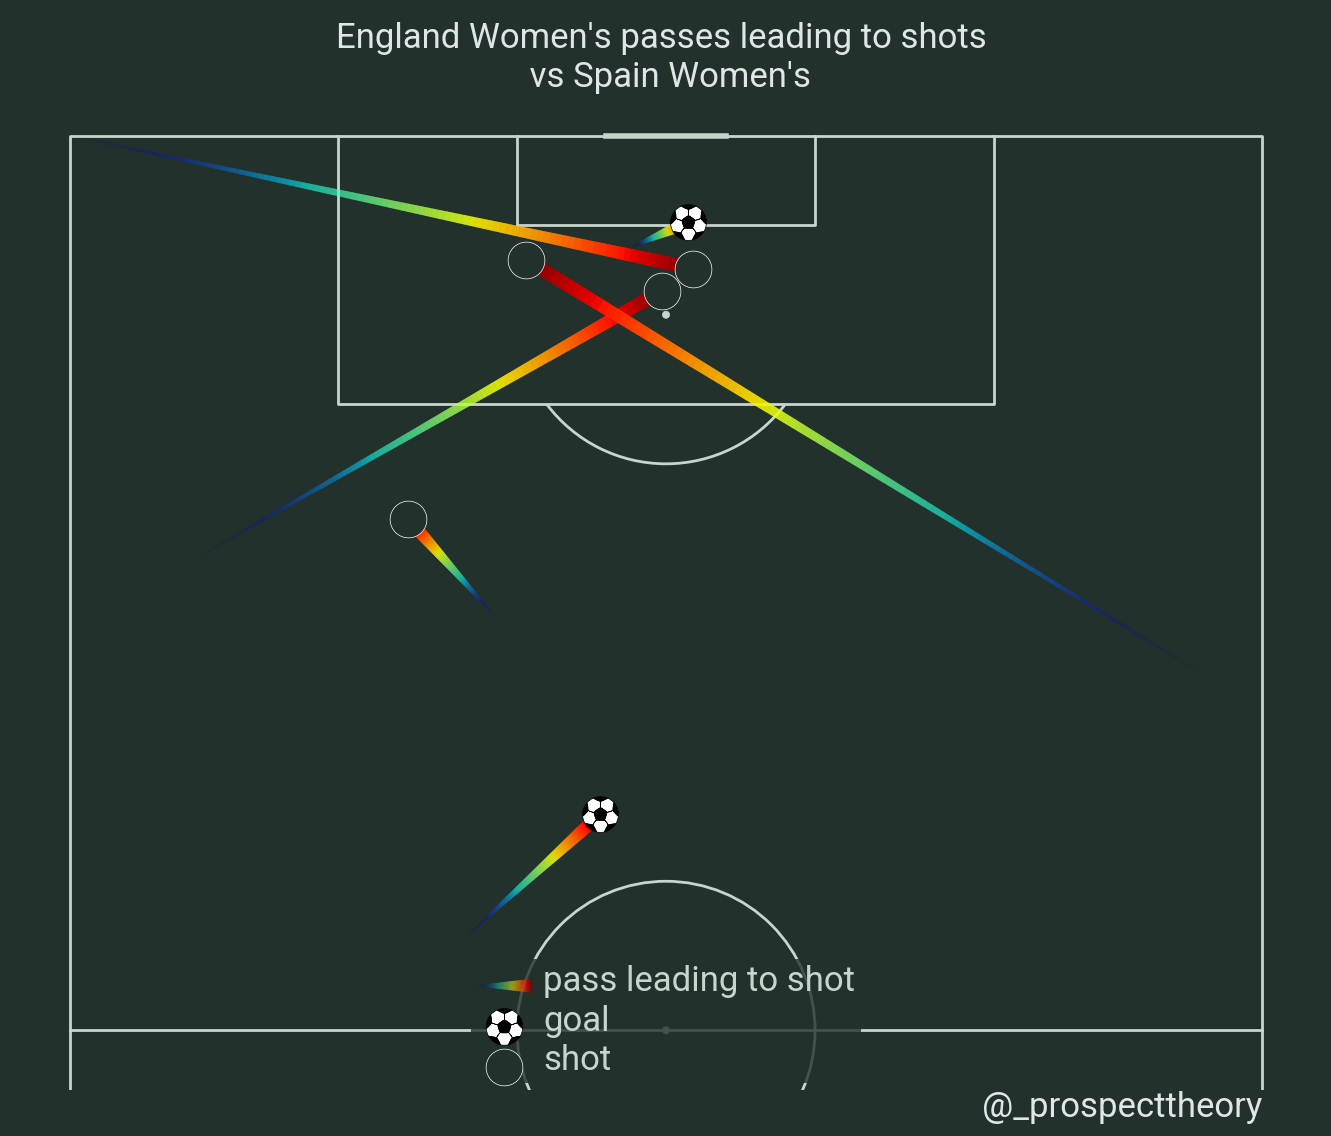

In [503]:
rcParams['text.color'] = '#c7d5cc'  # set the default text color


# Setup the pitch
pitch = VerticalPitch(pitch_type='statsbomb', pitch_color='#22312b', line_color='#c7d5cc',
                      half=True, pad_top=2)
fig, axs = pitch.grid(endnote_height=0.03, endnote_space=0, figheight=12,
                      title_height=0.08, title_space=0, axis=False,
                      grid_height=0.82)
fig.set_facecolor('#22312b')

# Plot the completed passes
pitch.lines(df_pass.x, df_pass.y, df_pass.end_x, df_pass.end_y,
            lw=10, transparent=True, comet=True, cmap='jet',
            label='pass leading to shot', ax=axs['pitch'])

# Plot the goals
pitch.scatter(df_pass[mask_goal].end_x, df_pass[mask_goal].end_y, s=700,
              marker='football', edgecolors='black', c='white', zorder=2,
              label='goal', ax=axs['pitch'])
pitch.scatter(df_pass[~mask_goal].end_x, df_pass[~mask_goal].end_y,
              edgecolors='white', c='#22312b', s=700, zorder=2,
              label='shot', ax=axs['pitch'])

# endnote and title
axs['endnote'].text(1, 0.5, '@_prospecttheory', va='center', ha='right', fontsize=25,
                    fontproperties=robotto_regular.prop, color='#dee6ea')
axs['title'].text(0.5, 0.5, f'{TEAM1} passes leading to shots \n vs {TEAM2}', color='#dee6ea',
                  va='center', ha='center',
                  fontproperties=robotto_regular.prop, fontsize=25)

# set legend
legend = axs['pitch'].legend(facecolor='#22312b', edgecolor='None',
                             loc='lower center', handlelength=4)
for text in legend.get_texts():
    text.set_fontproperties(robotto_regular.prop)
    text.set_fontsize(25)

plt.show()

## Anatomy of a goal

To discect how a score happened, it can be helpful to take a snapshot at the moment of the shot and see where everybody was at. That's why this goal freeze view might provide value.

### Gathering and preparing data 

In [504]:
# get event and lineup dataframes for game 7478
# event data
parser = Sbopen()
df_event, df_related, df_freeze, df_tactics = parser.event(3844384)

# lineup data
df_lineup = parser.lineup(3844384)
df_lineup = df_lineup[['player_id', 'jersey_number', 'team_name']].copy()

In [505]:
# Checking for goals
df_event[(df_event['minute'] == 95) & df_event['shot_statsbomb_xg']>0]

,id,index,period,timestamp,minute,second,possession,duration,match_id,type_id,...,foul_committed_card_name,substitution_replacement_id,substitution_replacement_name,pass_goal_assist,ball_recovery_offensive,foul_committed_offensive,pass_no_touch,bad_behaviour_card_id,bad_behaviour_card_name,shot_one_on_one
3514,dab0ec83-2180-44cb-8d21-62ecee04ab65,3515,3,00:05:50,95,50,193,1.114345,3844384,16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [506]:
SHOT_ID = 'dab0ec83-2180-44cb-8d21-62ecee04ab65'
df_freeze_frame = df_freeze[df_freeze.id == SHOT_ID].copy()
df_shot_event = df_event[df_event.id == SHOT_ID].dropna(axis=1, how='all').copy()

# add the jersey number
df_freeze_frame = df_freeze_frame.merge(df_lineup, how='left', on='player_id')

In [507]:
# strings for team names
team1 = df_shot_event.team_name.iloc[0]
team2 = list(set(df_event.team_name.unique()) - {team1})[0]

# subset the team shooting, and the opposition (goalkeeper/ other)
df_team1 = df_freeze_frame[df_freeze_frame.team_name == team1]
df_team2_goal = df_freeze_frame[(df_freeze_frame.team_name == team2) &
                                (df_freeze_frame.position_name == 'Goalkeeper')]
df_team2_other = df_freeze_frame[(df_freeze_frame.team_name == team2) &
                                 (df_freeze_frame.position_name != 'Goalkeeper')]

### Plotting the goal freeze

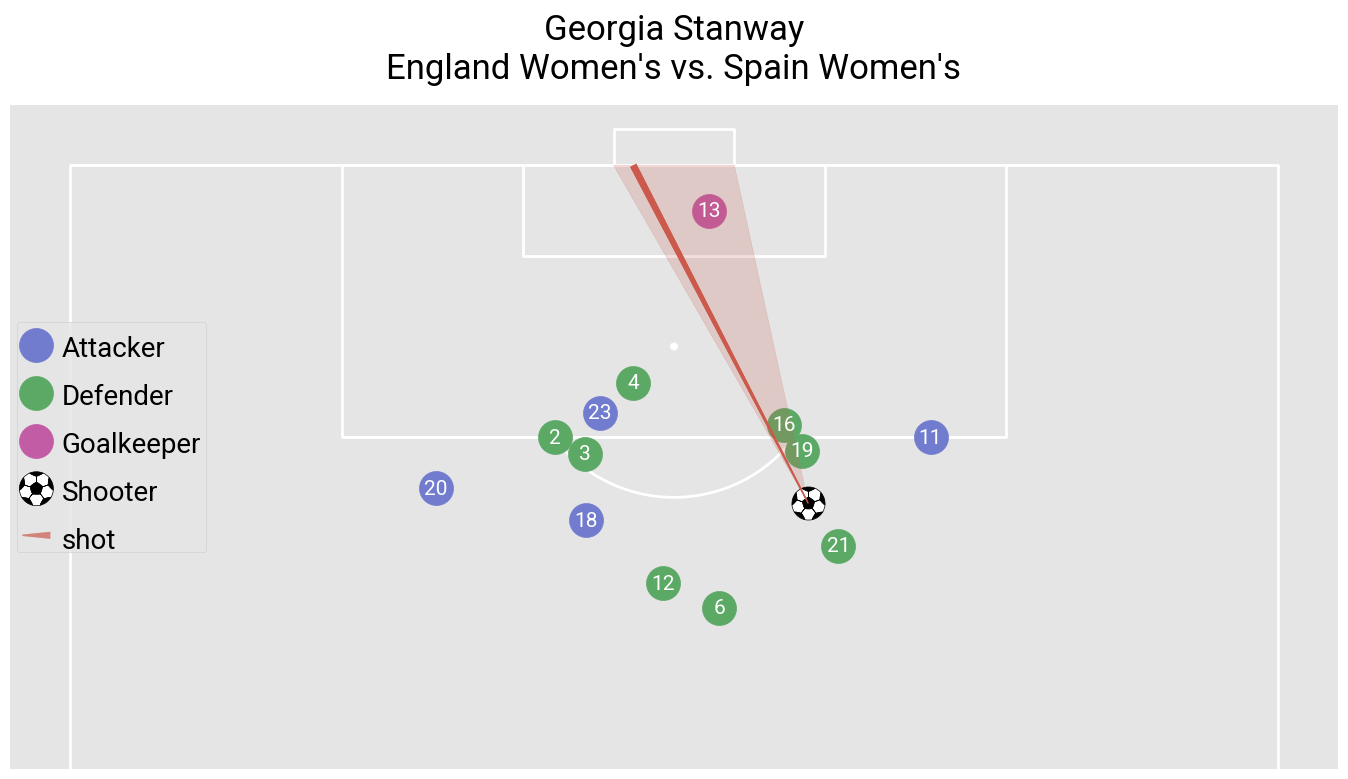

In [508]:
# Setup the pitch
pitch = VerticalPitch(half=True, goal_type='box', pad_bottom=-20)

# We will use mplsoccer's grid function to plot a pitch with a title axis.
fig, axs = pitch.grid(figheight=8, endnote_height=0,  # no endnote
                      title_height=0.1, title_space=0.02,
                      # Turn off the endnote/title axis. I usually do this after
                      # I am happy with the chart layout and text placement
                      axis=False,
                      grid_height=0.83)

# Plot the players
sc1 = pitch.scatter(df_team1.x, df_team1.y, s=600, c='#727cce', label='Attacker', ax=axs['pitch'])
sc2 = pitch.scatter(df_team2_other.x, df_team2_other.y, s=600,
                    c='#5ba965', label='Defender', ax=axs['pitch'])
sc4 = pitch.scatter(df_team2_goal.x, df_team2_goal.y, s=600,
                    ax=axs['pitch'], c='#c15ca5', label='Goalkeeper')

# plot the shot
sc3 = pitch.scatter(df_shot_event.x, df_shot_event.y, marker='football',
                    s=600, ax=axs['pitch'], label='Shooter', zorder=1.2)
line = pitch.lines(df_shot_event.x, df_shot_event.y,
                   df_shot_event.end_x, df_shot_event.end_y, comet=True,
                   label='shot', color='#cb5a4c', ax=axs['pitch'])

# plot the angle to the goal
pitch.goal_angle(df_shot_event.x, df_shot_event.y, ax=axs['pitch'], alpha=0.2, zorder=1.1,
                 color='#cb5a4c', goal='right')

# fontmanager for google font (robotto)
robotto_regular = FontManager()

# plot the jersey numbers
for i, label in enumerate(df_freeze_frame.jersey_number):
    pitch.annotate(label, (df_freeze_frame.x[i], df_freeze_frame.y[i]),
                   va='center', ha='center', color='white',
                   fontproperties=robotto_regular.prop, fontsize=15, ax=axs['pitch'])

# add a legend and title
legend = axs['pitch'].legend(loc='center left', labelspacing=1.5)
for text in legend.get_texts():
    text.set_fontproperties(robotto_regular.prop)
    text.set_fontsize(20)
    text.set_va('center')
    text.set_color('black')

# title
axs['title'].text(0.5, 0.5, f'{df_shot_event.player_name.iloc[0]}\n{team1} vs. {team2}',
                  va='center', ha='center', color='black',
                  fontproperties=robotto_regular.prop, fontsize=25)

plt.show()  # If you are using a Jupyter notebook you do not need this line